# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:
- Exited — факт ухода клиента

## Подготовка данных

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

### Читаем csv файл, выводим данные на экран, смотрим общую информацию

In [2]:
data=pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


После выгрузки данных мы увидели, что пропуски присутствуют в данных о количестве недвижимости у клиента, также некорректный тип у этих данных.

### Обработка пропусков и преобразование типа данных.

In [4]:
data['Tenure'].isna().sum()

909

In [5]:
data['Tenure']=data['Tenure'].fillna(0.0)

In [6]:
data['Tenure']=data['Tenure'].astype('Int64')

Пропуски в данных о количестве недвижимости у клиента заменили на 0, т.к предпологаем,что если данные не указаны,значит недвижимости у клиента нет. Тип данных изменили на целочисленный.

### Проверка на наличие дубликатов.

In [7]:
data.duplicated().sum()

0

Дубликатов в данных нет.

### Проверка на мультиколлинеарность

In [8]:
data.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,0.000596,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.015747,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000596,-0.015747,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,0.011225,-0.013319
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.011225,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Сильных парных линейных связей (т.е. корреляция, >0,7) не наблюдаем.

### Подготовка данных для исследования.

Удалим столбцы не несущие ценности для алгоритма (индекс строки в данных,уникальный идентификатор клиента,фамилия)

In [9]:
for_drop = ['RowNumber','CustomerId', 'Surname']
data = data.drop(for_drop, axis=1)

Преобразум категориальные признаки в численные техникой прямого кодирования, или отображения (One-Hot Encoding, OHE).

In [10]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Формирование выборок: обучающая, валидационная, тестовая

Так как у нас нет отдельной тестовой выборки разобьем данные на три части: обучающую, валидационную и тестовую. Данные разобьем  в соотношении 3:1:1 соответственно.

In [11]:
features = data_ohe.drop(['Exited'], axis=1) # извлекаем признаки
target = data_ohe['Exited'] # извлекаем целевой признак

Сначала выделим 60% данных под обучение модели

In [12]:
features_train, features_unit, target_train, target_unit = train_test_split(
    features, target, test_size=0.4, random_state=12345)
print(features_train.shape)
print(features_unit.shape)  

(6000, 11)
(4000, 11)


Осавшиеся 40% данных разделим пополам на валидационную и тестовую выборки

In [13]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_unit, target_unit, test_size=0.5, random_state=12345)
print(features_valid.shape)
print(features_test.shape)  

(2000, 11)
(2000, 11)


### Масштабирование признаков

Для масштабирования зафиксируем численные признаки

In [14]:
numeric = ['CreditScore', 'Tenure', 'Age','EstimatedSalary','Balance','NumOfProducts']

Создаём объект структуры StandardScaler() и настраиваем его на обучающих данных и масштабируем численные признаки.

In [40]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None
features_train[numeric].head()

,CreditScore,Tenure,Age,EstimatedSalary,Balance,NumOfProducts
454,1.107585,0.466088,0.011482,-0.757878,0.819420,-0.899779
8307,-0.338704,-0.496821,-0.844298,-1.194506,0.923294,-0.899779
4811,-0.782922,0.787058,-1.224645,0.212357,-1.220083,0.811234
1132,-0.235398,-1.459730,-0.178692,1.239310,-1.220083,0.811234
9640,1.024940,-0.496821,-0.368865,1.583001,-1.220083,-0.899779


В процессе поготовки данных избавились от пропусков, привели данные к корректному типу. Избавились от данных не представляющих ценности для алгоритма, преобразовали категориальные признаки в численные техникой прямого кодирования, сформировали обучающую, валидационную и тестовую выборки. Промасштабировали численные признаки. Теперь данные готовы к исследованию.

## Исследование задачи

### Исследуем баланс классов.


0    0.7963
1    0.2037
Name: Exited, dtype: float64


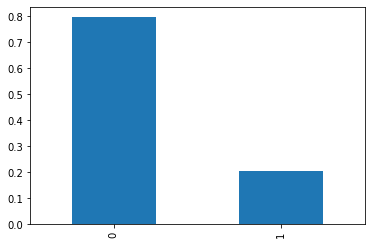

In [16]:
class_frequency=target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

В нашей задаче наблюдается сильный дисбаланс классов целевого признака.

### Изучим модели без учёта дисбаланса

Для определения качества моделей напишим функцию нахождения полноты, точности и F1-меры, а так же рассмотрим метрику AUC-ROC(площадь под ROC-кривой). Значение AUC-ROC случайной модели равно 0.5

In [17]:
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))
    print("AUC-ROC", roc_auc_score(target_valid, prediction))

#### Модель для классификации алгоритмом — логистической регрессии.

In [18]:
%%time
model_log = LogisticRegression(random_state=12345,solver='liblinear')  
model_log.fit(features_train, target_train) 
prediction = model_log.predict(features_valid)
rec_prec_f1(target_valid, prediction)

Полнота 0.23684210526315788
Точность 0.5657142857142857
F1-мера 0.33389544688026984
AUC-ROC 0.5944008250715284
CPU times: user 71.3 ms, sys: 54.2 ms, total: 126 ms
Wall time: 82.1 ms


#### Модель для классификации деревом решений

In [19]:
%%time
model_tree = DecisionTreeClassifier(random_state=12345) 
model_tree.fit(features_train, target_train) 
prediction = model_tree.predict(features_valid) 
rec_prec_f1(target_valid, prediction)

Полнота 0.47129186602870815
Точность 0.48883374689826303
F1-мера 0.47990255785627284
AUC-ROC 0.6705384741015855
CPU times: user 42.1 ms, sys: 8.45 ms, total: 50.5 ms
Wall time: 48.1 ms


#### Модель для классификации алгоритмом - "случайный лес"

In [20]:
%%time
model_forest = RandomForestClassifier(random_state=12345) 
model_forest.fit(features_train, target_train) 
prediction = model_forest.predict(features_valid)
rec_prec_f1(target_valid, prediction)

Полнота 0.44019138755980863
Точность 0.757201646090535
F1-мера 0.556732223903177
AUC-ROC 0.7014484118582861
CPU times: user 111 ms, sys: 2.84 ms, total: 114 ms
Wall time: 143 ms


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Рассчитайтем матрицу ошибок модели для классификации алгоритмом - "случайный лес"

In [21]:
prediction = model_forest.predict(features_valid)
confusion_matrix(target_valid, prediction)

array([[1523,   59],
       [ 234,  184]])

Случайный лес дает большое значение FN, что говорит о том, что модель часто дает ошибки в нахожнении положительного результата "1".

Чтобы посмотреть, как сильно наша модель отличается от случайной, построим ROC-кривую.

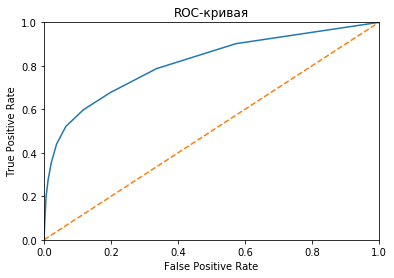

In [22]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

### Вывод по моделям не учитывающим дисбаланс данных.

Наилучший результат дала модель с случайным лесом, но у нее низкое значние F1 - меры, свидетельствующее о низком качестве модели, проблема в низком значении полноты.

## Борьба с дисбалансом

Избавимся от дисбаланса в наших данных прменив два метода: метод взвешивания классов и метод увеличения выборки. И найдем модель дающую наибольшее значение метрики F1 (Cреднее гармоническое полноты и точности.)

### Взвешивание классов

Избавимся от дисбаланса, придавая объектам редкого класса больший вес.

#### Модель для классификации алгоритмом — логистической регрессии.

In [23]:
%%time
best_result = 0
model_log_balanced = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model_log_balanced.fit(features_train, target_train)
prediction = model_log_balanced.predict(features_valid)
rec_prec_f1(target_valid, prediction)

Полнота 0.6842105263157895
Точность 0.3803191489361702
F1-мера 0.4888888888888888
AUC-ROC 0.6948233415396898
CPU times: user 71.8 ms, sys: 86.6 ms, total: 158 ms
Wall time: 166 ms


####  Модель для классификации деревом решений

In [24]:
%%time
model_tree_balanced = DecisionTreeClassifier(random_state=12345,max_depth=5,class_weight='balanced') 
model_tree_balanced.fit(features_train, target_train)
prediction = model_tree_balanced.predict(features_valid)    
rec_prec_f1(target_valid, prediction)

Полнота 0.6698564593301436
Точность 0.5374280230326296
F1-мера 0.5963791267305644
AUC-ROC 0.7587588238496482
CPU times: user 32.4 ms, sys: 817 µs, total: 33.2 ms
Wall time: 30.9 ms


#### Модель для классификации алгоритмом - "случайный лес"

In [25]:
%%time
model_forest_balanced = RandomForestClassifier(random_state=12345,
                                               n_estimators=100,
                                               class_weight='balanced') 
model_forest_balanced.fit(features_train,target_train)
prediction = model_forest_balanced.predict(features_valid)
rec_prec_f1(target_valid, prediction)

Полнота 0.44019138755980863
Точность 0.7965367965367965
F1-мера 0.5670261941448382
AUC-ROC 0.7052410793677678
CPU times: user 889 ms, sys: 23 ms, total: 912 ms
Wall time: 937 ms


### Увеличение выборки

Как мы выяснили ранее в нашей выборке отрицательных ответов ≈80% , положитительных ≈ 20%.
Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса.
- Разделим обучающую выборку на отрицательные и положительные объекты;
- Скопируем несколько раз положительные объекты;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.

In [26]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]


    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

0    0.501043
1    0.498957
Name: Exited, dtype: float64


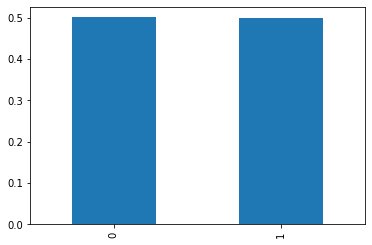

In [27]:
class_frequency=target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Дисбаланс данных отутствует.

#### Модель для классификации алгоритмом — логистической регрессии.

In [28]:
%%time
model_log_upsample = LogisticRegression(random_state=12345,solver='liblinear') 
model_log_upsample.fit(features_upsampled, target_upsampled) 
prediction = model_log_upsample.predict(features_valid)
rec_prec_f1(target_valid, prediction)

Полнота 0.6842105263157895
Точность 0.3803191489361702
F1-мера 0.4888888888888888
AUC-ROC 0.6948233415396898
CPU times: user 150 ms, sys: 78.9 ms, total: 229 ms
Wall time: 169 ms


#### Модель для классификации деревом решений

In [29]:
%%time
model_tree_upsample = DecisionTreeClassifier(random_state=12345,max_depth=5,class_weight='balanced') 
model_tree_upsample.fit(features_train, target_train) 
prediction = model_tree_upsample.predict(features_valid) 
rec_prec_f1(target_valid, prediction)

Полнота 0.6698564593301436
Точность 0.5374280230326296
F1-мера 0.5963791267305644
AUC-ROC 0.7587588238496482
CPU times: user 32.3 ms, sys: 626 µs, total: 32.9 ms
Wall time: 106 ms


####  Модель для классификации алгоритмом - "случайный лес"

In [30]:
%%time
model_forest_upsample = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_forest_upsample.fit(features_upsampled, target_upsampled)
prediction = model_forest_upsample.predict(features_valid)
rec_prec_f1(target_valid, prediction)

Полнота 0.5382775119617225
Точность 0.6756756756756757
F1-мера 0.5992010652463382
AUC-ROC 0.7350047483955262
CPU times: user 1.32 s, sys: 4.13 ms, total: 1.32 s
Wall time: 1.34 s


### Вывод по моделям учитывающим дисбаланс данных.

Избавившись от дисбаланса данных мы значительно улучшили качество модели, так значения метрики F1 и AUC-ROC увеличились. Лучший результат дал метод увеличения выборки и модель для классификации алгоритмом - "случайный лес". Попробуем улучшить эту модель перебирая гиперпараметры.

In [31]:
%%time
best_est = 0
best_depth = 0
best_model_forest_upsample = None
best_result = 0
for est in range(2,60,2):
    for depth in range(3,30,2):
        model_forest_upsample = RandomForestClassifier(random_state=12345, 
                                              n_estimators=est, 
                                              max_depth=depth) 
        model_forest_upsample.fit(features_upsampled,target_upsampled) 
        predicted_valid = model_forest_upsample.predict(features_valid)
        result = f1_score(target_valid,predicted_valid) 
        if result > best_result: 
            best_model_forest_upsample = model_forest_upsample 
            best_result = result 
            best_depth = depth     
            best_est = est
print("Количество деревьев наилучшей модели:", best_est,
      "Максимальная глубина:", best_depth)
rec_prec_f1(target_valid, best_model_forest_upsample.predict(features_valid))

Количество деревьев наилучшей модели: 54 Максимальная глубина: 13
Полнота 0.6244019138755981
Точность 0.6397058823529411
F1-мера 0.6319612590799032
AUC-ROC 0.7657407799466486
CPU times: user 2min 21s, sys: 195 ms, total: 2min 21s
Wall time: 2min 22s


Рассчитайтем матрицу ошибок нашей модели.

In [32]:
prediction = best_model_forest_upsample.predict(features_valid)
confusion_matrix(target_valid, prediction)

array([[1435,  147],
       [ 157,  261]])

Количество FP и FN практически одинаково, значит модель одинаково определяет как положительные так и отрицательные исходы, что важно для нашей задачи.

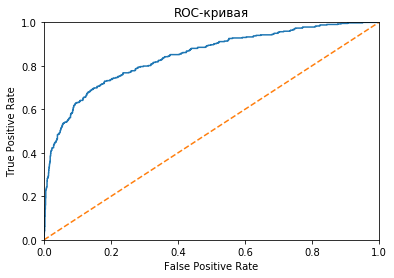

In [33]:
probabilities_valid = best_model_forest_upsample.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# 4. Тестирование модели

Для тестирования модели заново разобьем данные на две части: 80% - обучающая и 20% - тестовая. 

In [34]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
print(features_train.shape)
print(features_test.shape)

(8000, 11)
(2000, 11)


Отмасштабируем численные признаки.

In [35]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
454,1.107585,0.011482,0.466088,0.819420,-0.899779,0,1,-0.757878,0,0,0
8307,-0.338704,-0.844298,-0.496821,0.923294,-0.899779,1,1,-1.194506,0,0,1
4811,-0.782922,-1.224645,0.787058,-1.220083,0.811234,1,0,0.212357,0,1,0
1132,-0.235398,-0.178692,-1.459730,-1.220083,0.811234,1,1,1.239310,0,0,1
9640,1.024940,-0.368865,-0.496821,-1.220083,-0.899779,1,0,1.583001,0,0,0


Избавимся от дисбаланса данных техникой увеличения выборки.

In [36]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Проверим модель на тестовых данных.

In [37]:
%%time
best_model_forest_upsample.fit(features_upsampled,target_upsampled)
prediction = best_model_forest_upsample.predict(features_test)
rec_prec_f1(target_test, prediction)

Полнота 0.6088992974238876
Точность 0.6175771971496437
F1-мера 0.6132075471698112
AUC-ROC 0.7532735520813018
CPU times: user 878 ms, sys: 3.98 ms, total: 882 ms
Wall time: 888 ms


Рассчитайтем матрицу ошибок и построим ROC-кривую.

In [38]:
prediction = best_model_forest_upsample.predict(features_test)
confusion_matrix(target_test, prediction)

array([[1412,  161],
       [ 167,  260]])

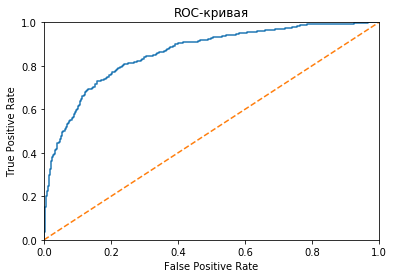

In [39]:
probabilities_test = best_model_forest_upsample.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Вывод

- При проведении исследования мы столкнулсь с проблемой дисбаланса(80% ответов целевого признака были негативными и только 20% позитивными) Все модели не первоначальных данных обладали низким качеством взвешенной величины (F1) — модели показывали низкие результаты точности или полноты.
- В ходе исследования проверили работу методов борьбы с дисбалансом "Взвешивание классов" и "Увеличение выборки". В нашем случае техника "Увеличение выборки" дала лучший результат и позволила построить модель заданного качества *F1*-мера не менее 0.59